## 📙 SET THE NAME AND MAIN PARAMETERS

In [1]:
enable_mixed_precision = True

## ⚙️ Import Libraries

In [12]:
import numpy as np

import tensorflow as tf
import keras as tfk
from keras import mixed_precision
from keras.mixed_precision import LossScaleOptimizer
from keras import layers as tfkl
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import Model
from keras.applications import ConvNeXtTiny, VGG16, VGG19 # Add more
from keras.models import load_model
import keras_cv

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt

from datetime import datetime

from tqdm import tqdm

import math

In [3]:
print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

Tensorflow version -> 2.16.1
Keras version -> 3.3.3


In [4]:
# Set the keras global policy to mixed precision
if enable_mixed_precision:
    mixed_precision.set_global_policy('mixed_float16')
    print(mixed_precision.global_policy())

<FloatDTypePolicy "mixed_float16">


In [5]:
# Set random seed
seed = 42
np.random.seed(42)
tf.random.set_seed(42)

## ⏳ Load the Data

In [6]:
# Load data
data = np.load("/kaggle/input/hbntlualk-khahzla-zwspa/augmented_split_dataset.npz")

In [7]:
print(data.keys())

KeysView(NpzFile '/kaggle/input/hbntlualk-khahzla-zwspa/augmented_split_dataset.npz' with keys: X_train, X_test, y_train, y_test)


In [8]:
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [9]:
print(X_test.shape, y_test.shape)

(1793, 96, 96, 3) (1793, 8)


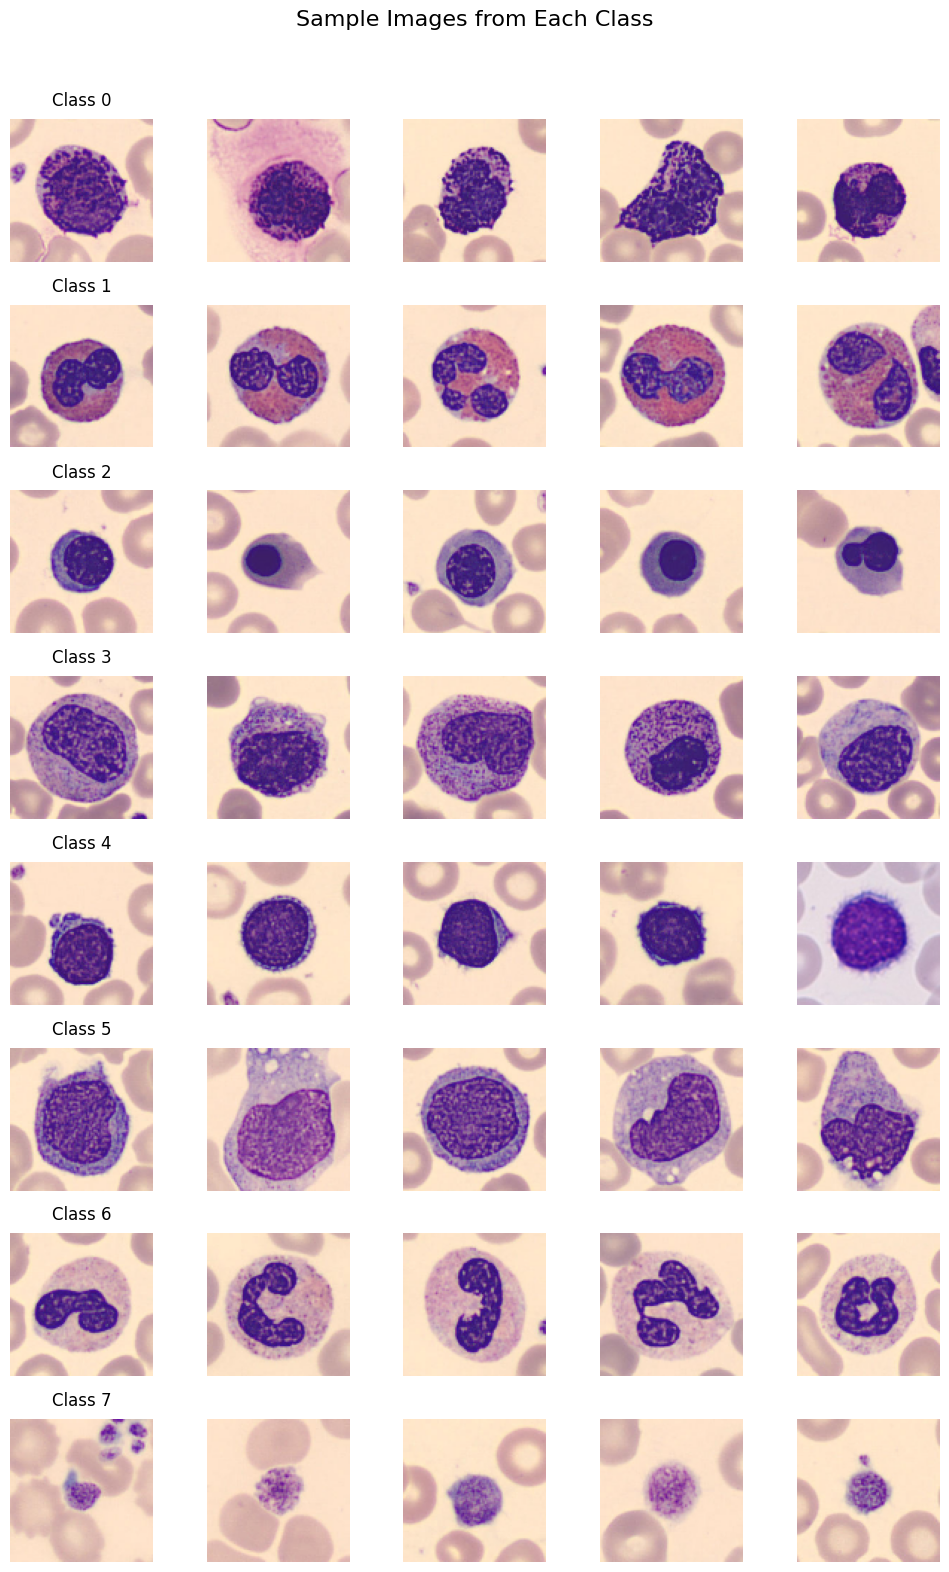

In [10]:
# Number of samples to display per class
samples_per_class = 5
unique_classes = range(y_test.shape[1])  # Assuming classes are labeled from 0 to n-1

# Adjust figure size and remove extra spacing between plots
fig, axes = plt.subplots(len(unique_classes), samples_per_class, figsize=(samples_per_class * 2, len(unique_classes) * 2))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for class_idx in unique_classes:
    # Find indices of samples for this class
    class_indices = np.where(np.argmax(y_test, axis=1) == class_idx)[0]
    # Randomly select images from this class
    selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)

    for i, idx in enumerate(selected_indices):
        ax = axes[class_idx, i]
        ax.imshow(X_test[idx].astype("uint8"))  # Convert to uint8 if needed for display
        ax.axis("off")
        if i == 0:
            ax.set_title(f"Class {class_idx}", fontsize=12, pad=10)  # Add padding to title    

# Adjust layout to reduce spacing
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [13]:
myModel = load_model('/kaggle/input/vgg_augmenteddata/keras/default/1/model.keras')

In [16]:
test_predictions = myModel.predict(X_test, verbose=0)

#Change following
multi_classes = np.zeros_like(test_predictions)
multi_classes[np.arange(len(test_predictions)), np.argmax(test_predictions, axis=-1)] = 1

indices_diff = np.where((multi_classes != y_test).any(axis=1))[0]
indices_equal = np.where((multi_classes == y_test).any(axis=1))[0]

misclassified = X_test[indices_diff]
correctlyClassified = X_test[indices_equal]


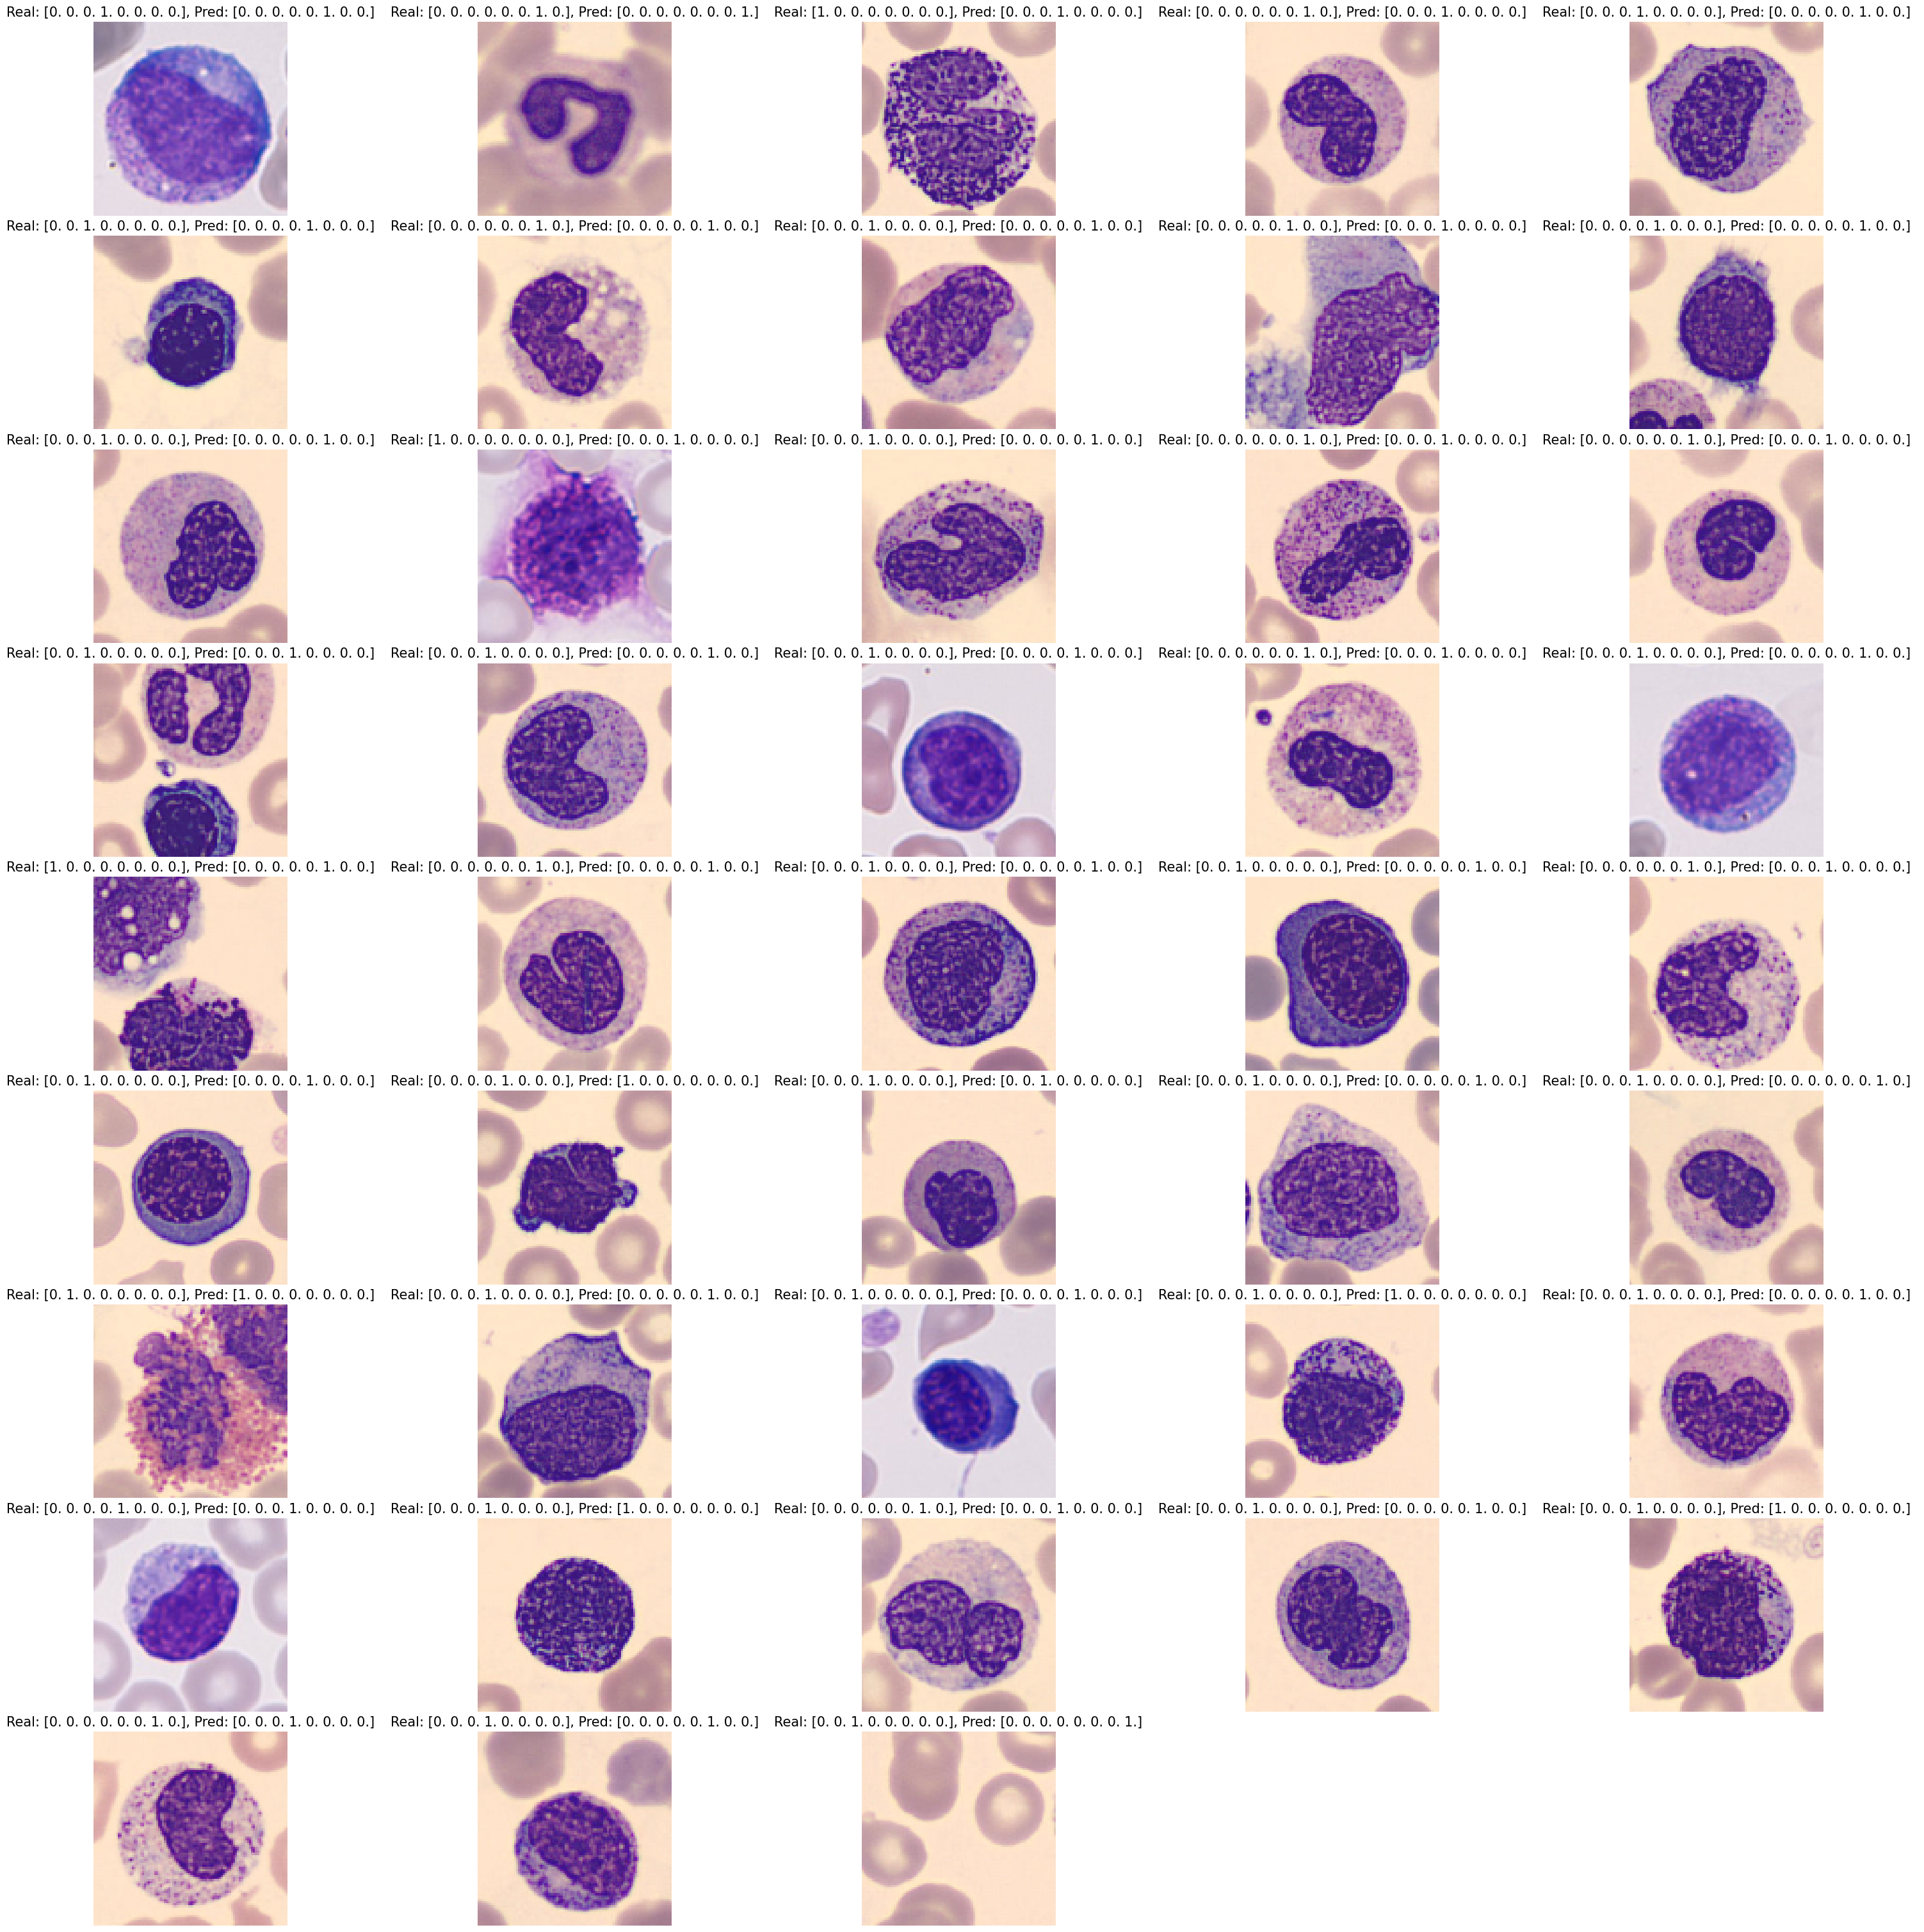

In [17]:
# Plot misclassified

num_img = len(misclassified)
num_cols = min(num_img, 5)  # Set the number of columns to 5

num_rows = (num_img - 1) // num_cols + 1  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30))

for i in range(num_img):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(np.clip(misclassified[i], 0, 255))
    ax.set_title(f"Real: {y_test[indices_diff[i]]}, Pred: {multi_classes[indices_diff[i]]}", fontsize=15)
    ax.axis('off')

# Hide any empty subplots
for i in range(num_img, num_rows * num_cols):
    ax = axes[i // num_cols, i % num_cols]
    ax.axis('off')

plt.tight_layout(pad=0.1, h_pad=0.5, w_pad=0.1)
plt.show()

In [18]:
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    #jet = cm.get_cmap("jet")
    jet = cm.get_cmap("viridis")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)


    #finalImages.append(superimposed_img)

    # Display Grad CAM
    #display(Image(cam_path, width=200, height=80))

    return superimposed_img

In [20]:
from tensorflow import keras

In [22]:
preds = myModel.predict(misclassified)


# Generate class activation heatmap
heatmaps = []
for img in misclassified:
    img = np.expand_dims(img, axis=0)
    # Make sure to train a model with this layer name
    heatmaps.append(make_gradcam_heatmap(img, myModel.get_layer("importedNetworkLayer"), "block5_conv3"))

finalMisclassifiedImages = []

for i in range(len(misclassified)):
    finalMisclassifiedImages.append(save_and_display_gradcam(misclassified[i], heatmaps[i]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 757ms/step


/tmp/ipykernel_30/2476989207.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("viridis")


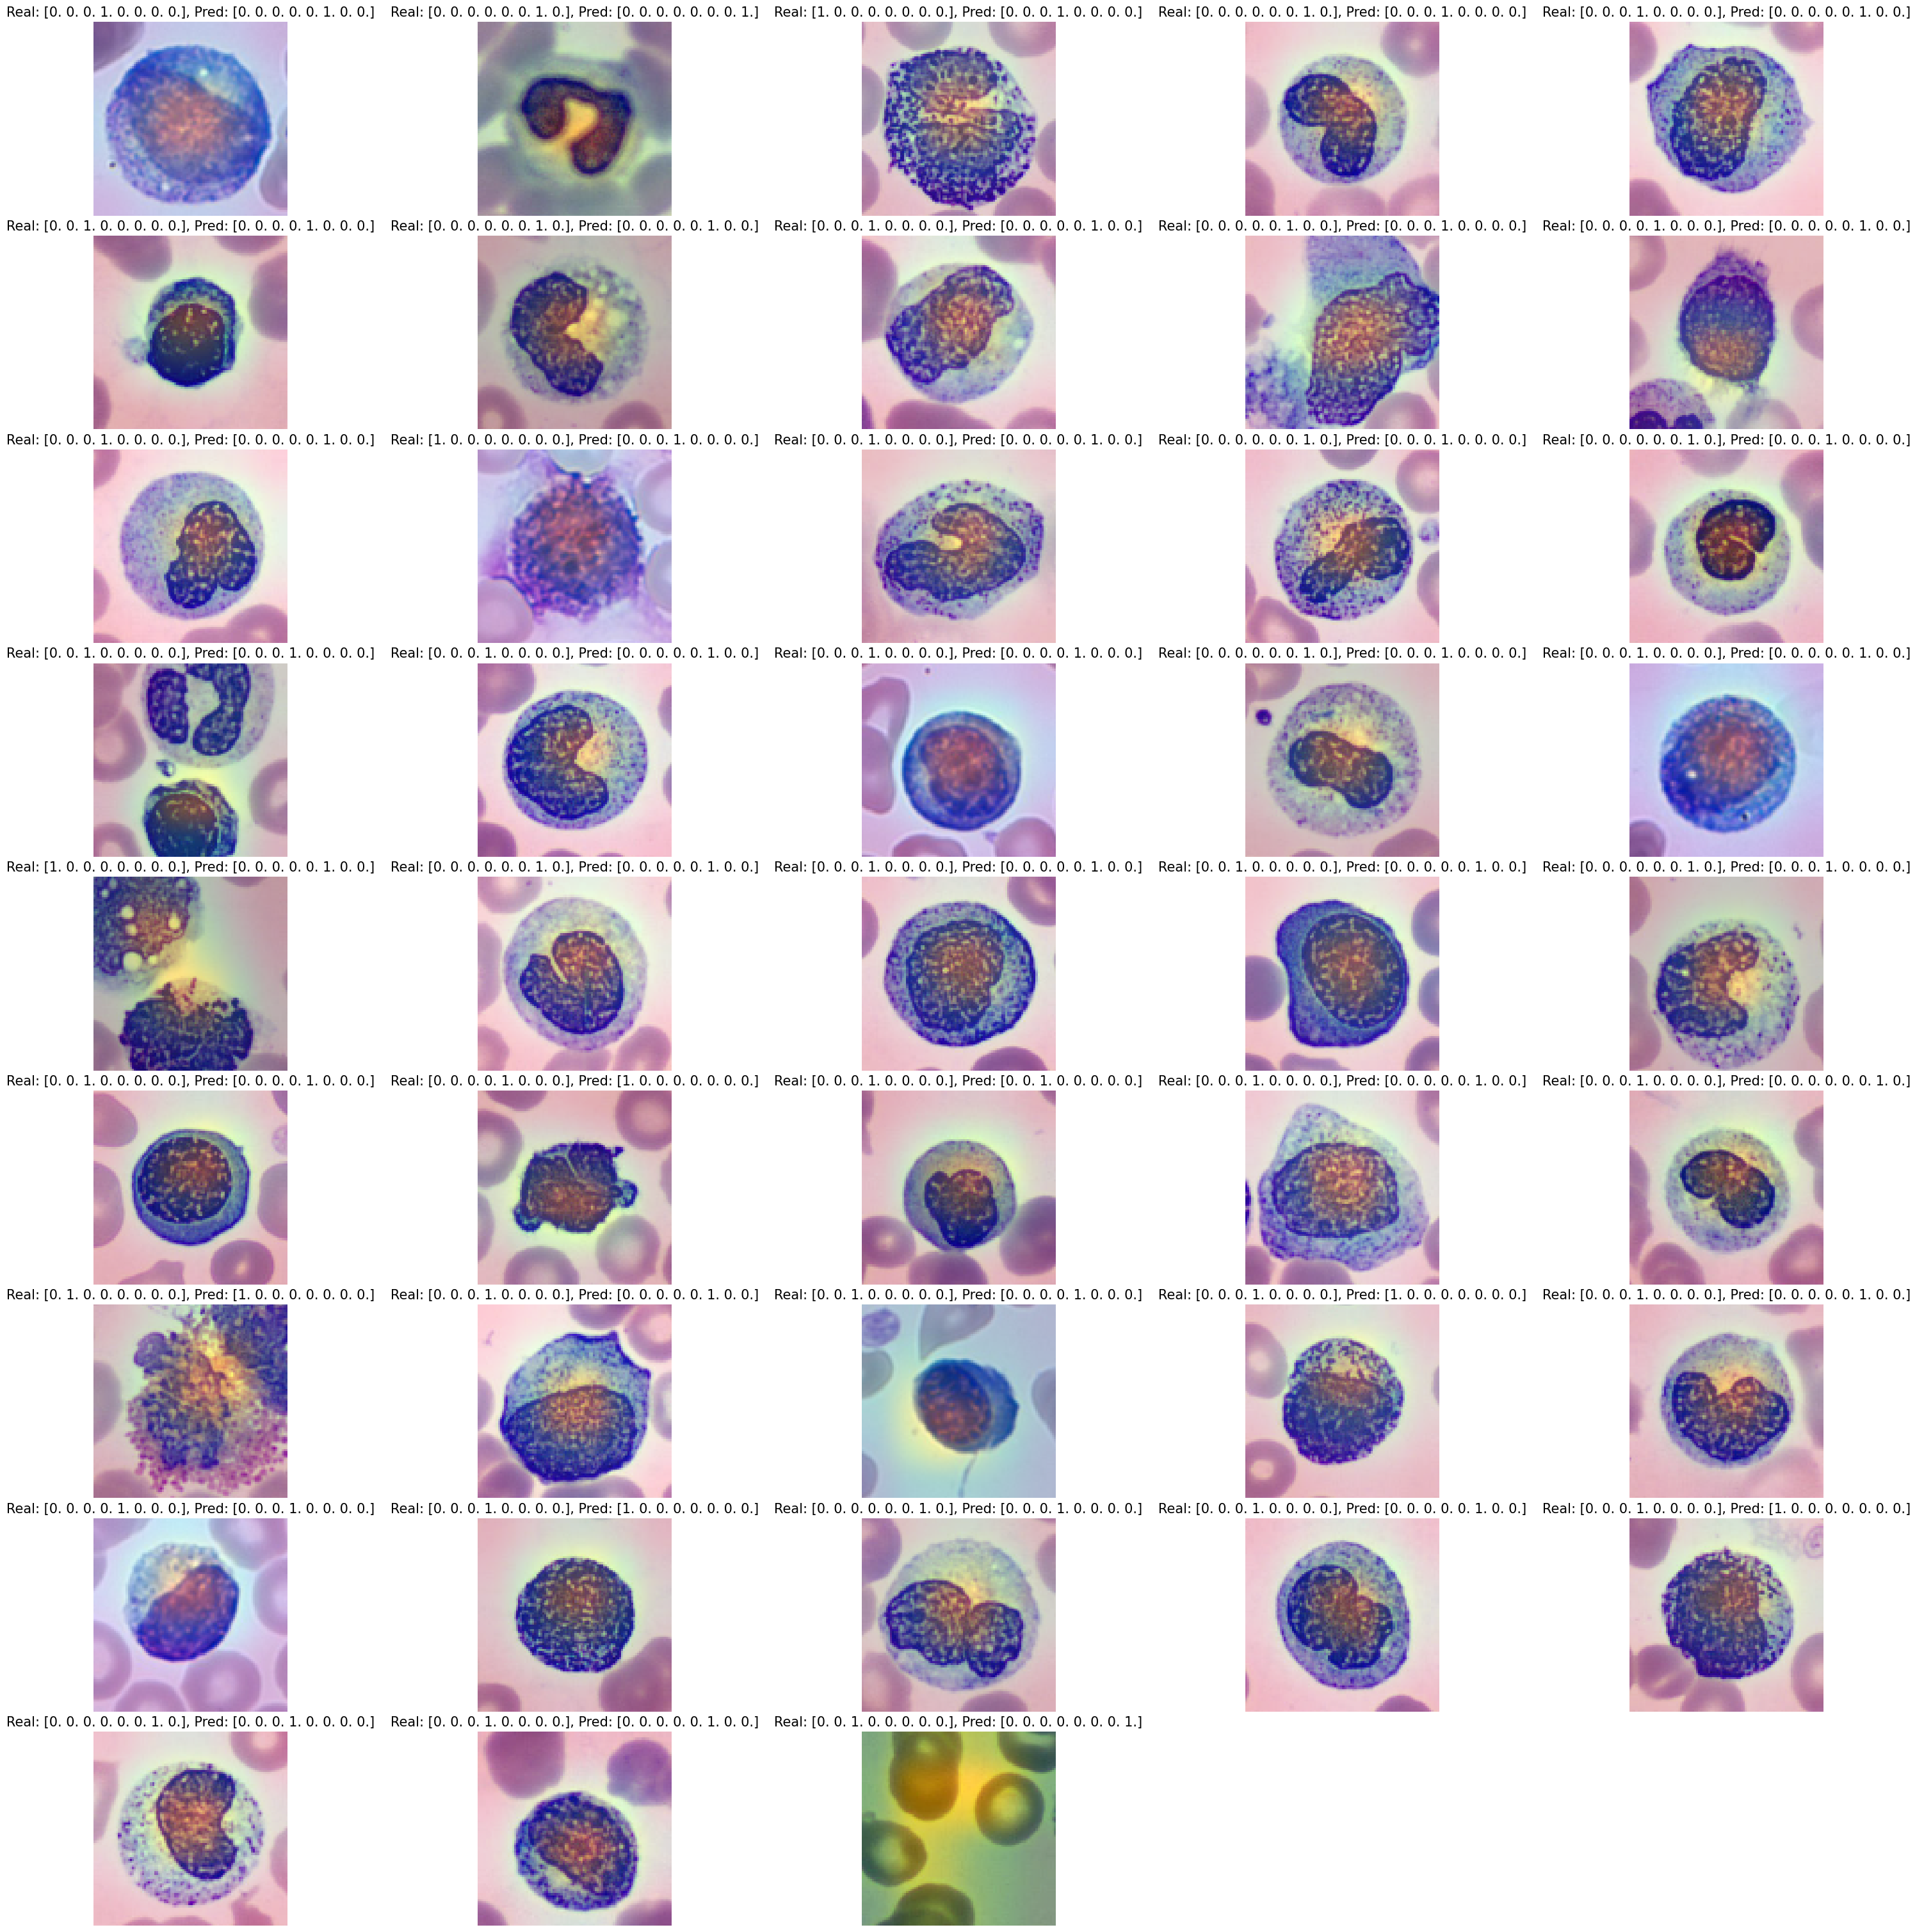

In [23]:
# Plot misclassified maps

num_img = len(finalMisclassifiedImages)
num_cols = min(num_img, 5)  # Set the number of columns to 5

num_rows = (num_img - 1) // num_cols + 1  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30))

for i in range(num_img):
    ax = axes[i // num_cols, i % num_cols]

    # Convert the IPython Image object to a NumPy array and display it
    img_array = np.array(finalMisclassifiedImages[i])
    ax.imshow(img_array)

    ax.set_title(f"Real: {y_test[indices_diff[i]]}, Pred: {multi_classes[indices_diff[i]]}", fontsize=15)
    ax.axis('off')

# Hide any empty subplots
for i in range(num_img, num_rows * num_cols):
    ax = axes[i // num_cols, i % num_cols]
    ax.axis('off')

plt.tight_layout(pad=0.1, h_pad=0.5, w_pad=0.1)
plt.show()

In [25]:
correctPreditcions = test_predictions[indices_equal]

# Prepare image
img_array = correctlyClassified

#selecting top 36
img_array = img_array[:36]

print(f"Correctly classified: {len(indices_equal)}")

# Remove last layer's softmax
myModel.get_layer("importedNetworkLayer").layers[-1].activation = None
preds = myModel.get_layer("importedNetworkLayer").predict(img_array*255)

preds = myModel.predict(img_array)

# Print what the top predicted class is
print(f"Len original predictions: {len(indices_equal)}")

finalCorrectImages = []

heatmapsCorrect = []
for img in img_array:
# Generate class activation heatmap
    img = np.expand_dims(img, axis=0)
    # Make sure ...
    heatmapsCorrect.append(make_gradcam_heatmap(img, myModel.get_layer("importedNetworkLayer"), "block5_conv3"))

for i in range(len(img_array)):
    finalCorrectImages.append(save_and_display_gradcam(img_array[i], heatmapsCorrect[i]))

Correctly classified: 1793
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step
Len original predictions: 1793


/tmp/ipykernel_30/2476989207.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("viridis")


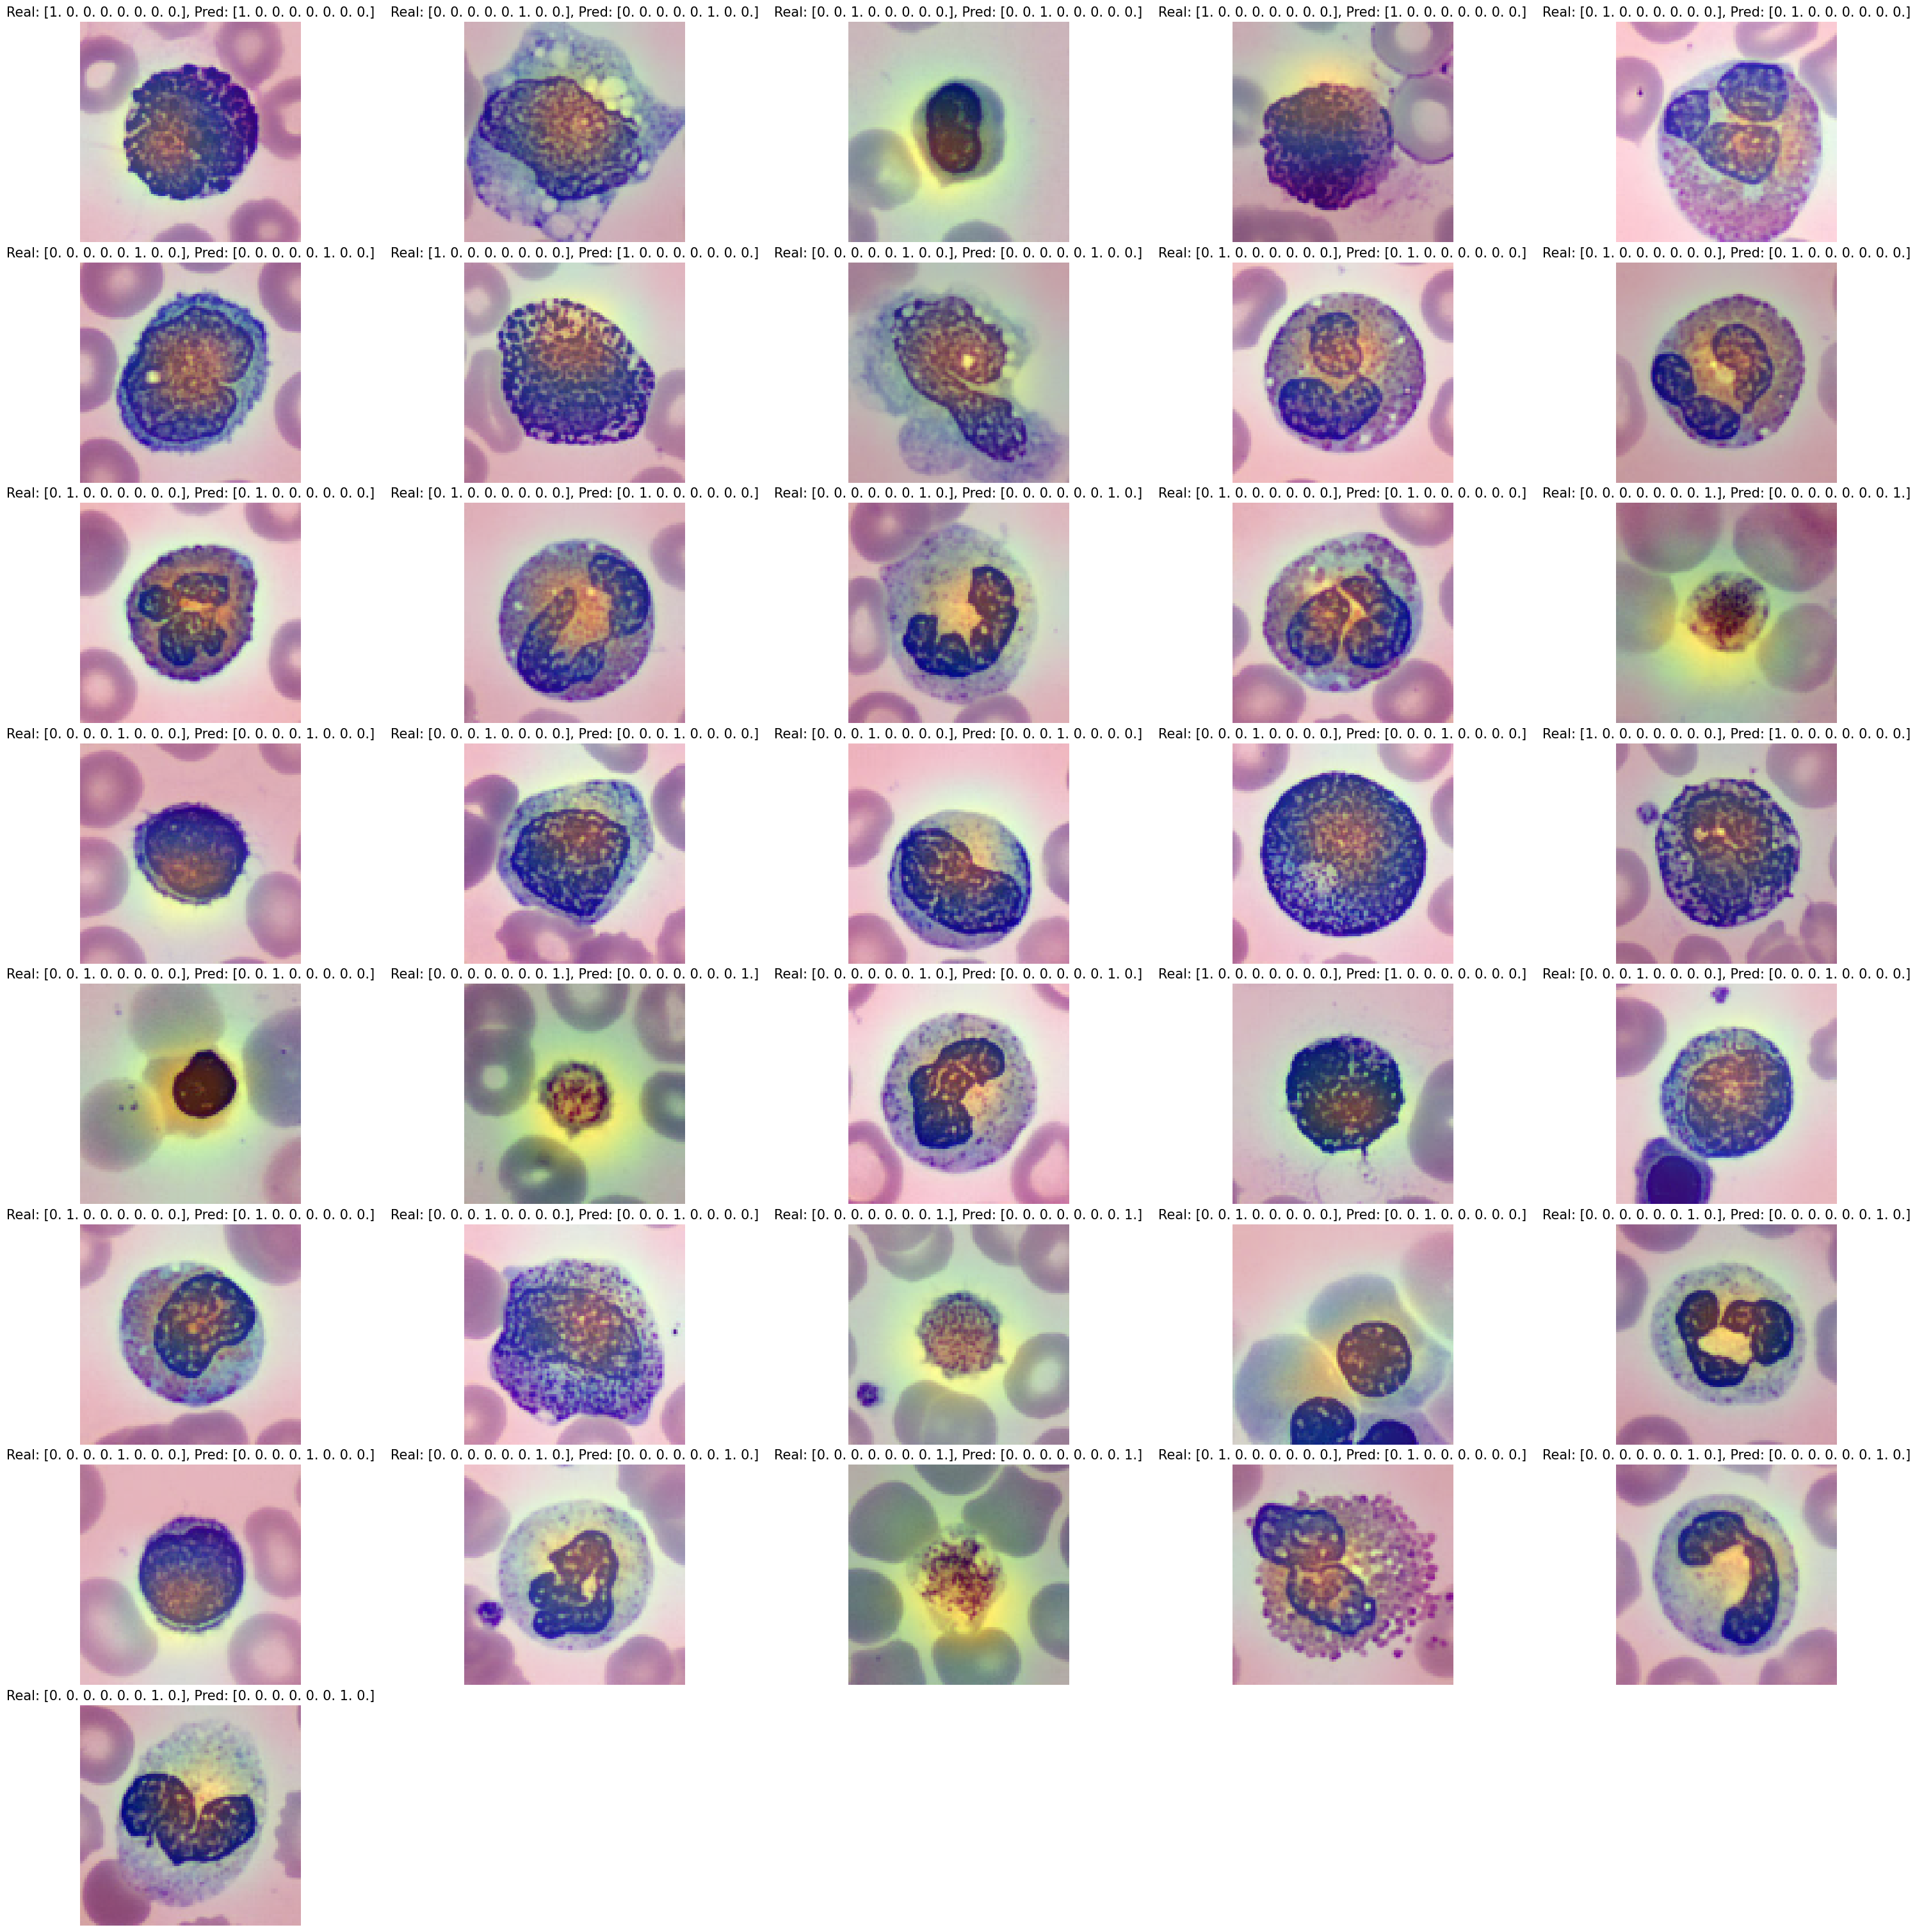

In [26]:
# Plot correct maps
num_img = len(finalCorrectImages)
num_cols = min(num_img, 5)  # Set the number of columns to 5

num_rows = (num_img - 1) // num_cols + 1  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30))

for i in range(num_img):
    ax = axes[i // num_cols, i % num_cols]

    img_array = np.array(finalCorrectImages[i])
    ax.imshow(img_array)
    ax.set_title(f"Real: {y_test[indices_equal[i]]}, Pred: {multi_classes[indices_equal[i]]}", fontsize=15)

    ax.axis('off')

# Hide any empty subplots
for i in range(num_img, num_rows * num_cols):
    ax = axes[i // num_cols, i % num_cols]
    ax.axis('off')

plt.tight_layout(pad=0.1, h_pad=0.5, w_pad=0.1)
plt.show()